In [1]:
import numpy as np

import lapgm
import view_utils
import brainweb_utils

# Data Acquisition
We will be using a variant of the *BrainWeb* dataset for our debiasing example. Example data will be downloaded once into the examples/data subfolder.

In [2]:
# Download and read BrainWeb normal data
brainweb_dict = brainweb_utils.get_biased_data()

brainweb_data = [brainweb_dict['T1'], brainweb_dict['T2'], brainweb_dict['PD']]

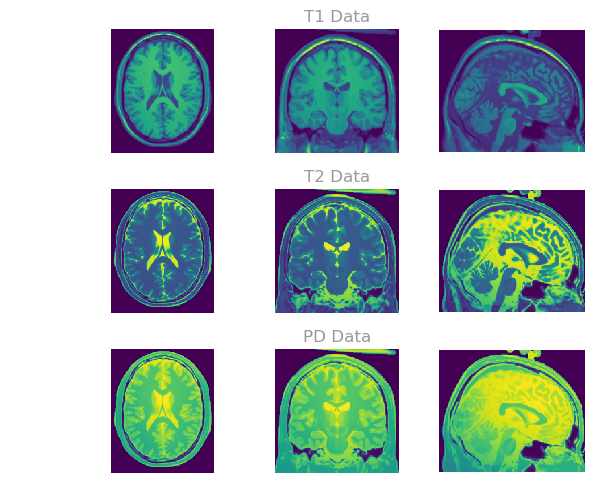

In [3]:
# Associated label data
class_data = brainweb_utils.download_and_read_phantom()
data_mask = class_data > 0

# View center slices of the BrainWeb dataset
view_utils.view_center_slices(brainweb_data, data_mask, ['T1 Data', 'T2 Data', 'PD Data'])

# Debias Setup and Run
LapGM can be run either on the CPU or GPU if appropriate packages are installed. Next cell specifies whether GPU compute should be used.

In [4]:
# Skip or comment out if GPU is not available
lapgm.use_gpu(True)

Next we set up the LapGM object by specifying settings and hyperparameters for the run.

In [5]:
# Computation can be saved by specifying a downscaling factor.
debias_obj = lapgm.LapGM(downscale_factor=2)

# -- Specify hyperparameters --
# tau is an inverse regularization strength on the estimated bias gradient
# n_classes specifies the number of tissue classes visible (including ambient space)
# log_initialize initializes clusters with log transform. Increases sensitivity to finding clusters
#     of similar intensity. For less dispersed bias fields it may be better to set to true.
debias_obj.set_hyperparameters(tau=5e-5, n_classes=6, log_initialize=False)

# Cast datatype and attach relevant sequence information
brainweb_arr = lapgm.to_sequence_array([brainweb_dict['T1'], brainweb_dict['T2'], brainweb_dict['PD']])

In [6]:
# Run debias procedure and take parameter output
params = debias_obj.estimate_parameters(brainweb_arr, print_tols=True)

iter: 0, Bdiff: inf
iter: 1, Bdiff: 0.5696179000928288
iter: 2, Bdiff: 0.21404021807132947
iter: 3, Bdiff: 0.09248469524379482
iter: 4, Bdiff: 0.04948570295875585
iter: 5, Bdiff: 0.03234488873215867
iter: 6, Bdiff: 0.01955022527622381
iter: 7, Bdiff: 0.013290828417944364
iter: 8, Bdiff: 0.009919704590767797
iter: 9, Bdiff: 0.007733647822409676
iter: 10, Bdiff: 0.006146669113848515
iter: 11, Bdiff: 0.004954532507926006
iter: 12, Bdiff: 0.004016983233231714
iter: 13, Bdiff: 0.003215670856829945
iter: 14, Bdiff: 0.0026031011360824474
iter: 15, Bdiff: 0.00213837346180132
iter: 16, Bdiff: 0.0017537363518075296
iter: 17, Bdiff: 0.001414725370245839
iter: 18, Bdiff: 0.0011395414506802906
iter: 19, Bdiff: 0.0009405882821713281
iter: 20, Bdiff: 0.0007864082966416293
iter: 21, Bdiff: 0.000686770452188816
iter: 22, Bdiff: 0.0006250599669031386
iter: 23, Bdiff: 0.0006816888307763671
iter: 24, Bdiff: 0.0007540485499576452


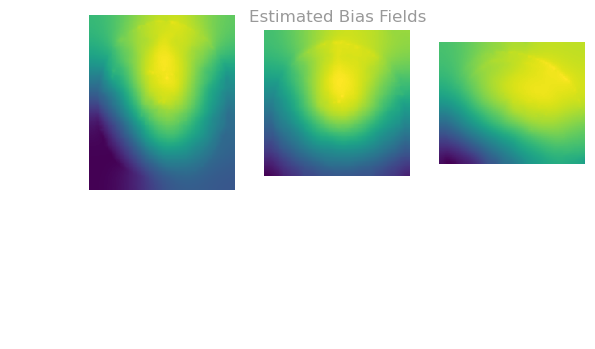

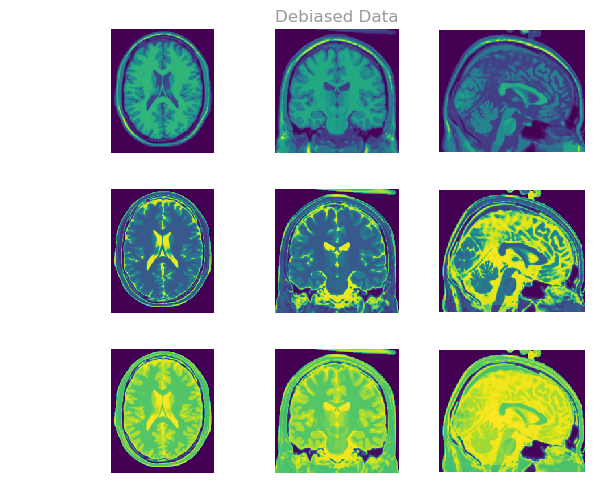

In [7]:
# View estimated bias field
view_utils.view_center_slices(np.exp(params.B), title_names=['Estimated Bias Fields'])

# Debias data
brainweb_deb = lapgm.debias(brainweb_arr, params)
# View debiased result
view_utils.view_center_slices(brainweb_deb, data_mask, ['Debiased Data', None, None])

A total of six classes were used in estimation while ten are provided in the ground truth phantom. As the number of classes increases, estimation becomes more difficult. This can be offset by estimating directly on the non-downsample data with tau value decreased accordingly.

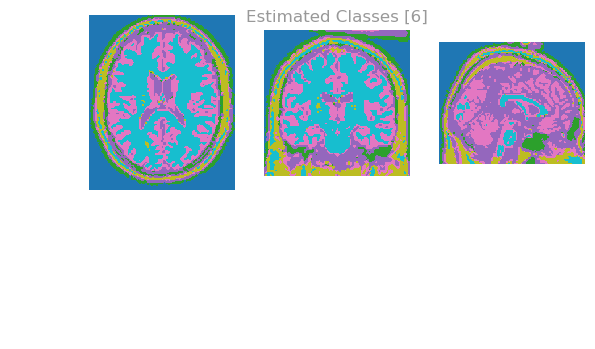

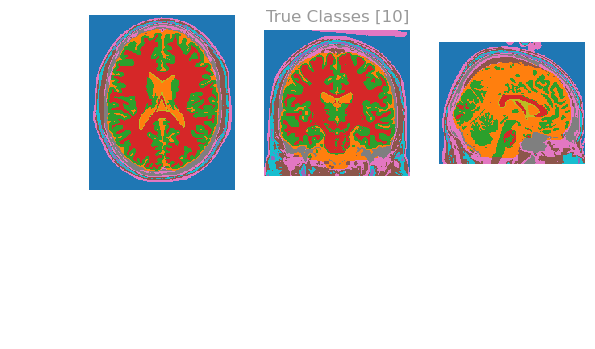

In [8]:
# 6 Class LapGM esimation with order dictacted by T1 means for consistent labels
view_utils.view_class_map(params.w, order=np.argsort(params.mu[:,0]), title_name='Estimated Classes [6]')

# 10 Class BrainWeb phantom
view_utils.view_center_slices(class_data, cmap_name='tab10', title_names=['True Classes [10]'])

# MR Normalization
It is possible that, across multiple MR scans, there will be slight variations in the intensity scalings of different MR images. To correct for this LapGM can normalize intensity values against prominent or bright tissue groups

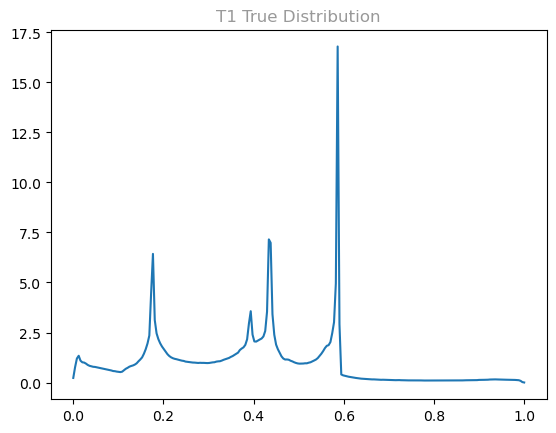

In [9]:
# Get clean BrainWeb T1 data
clean_t1 = brainweb_utils.download_and_read_normal(noise=0, rf_intensity=0)['T1']
view_utils.view_distributions(clean_t1, bandwidth=1e-2, mask_volume=data_mask,
                              title_name='T1 True Distribution')

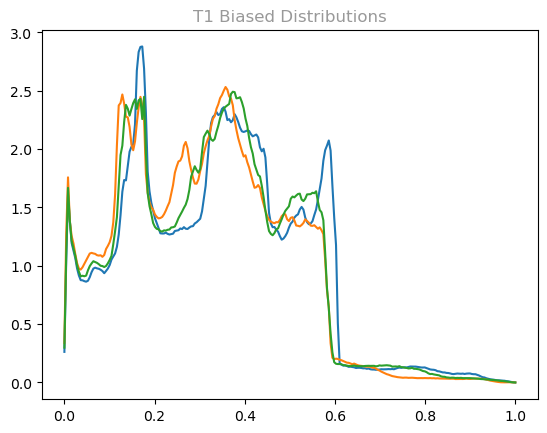

In [10]:
# Gather differently biased examples
brainweb_dict_ex0 = brainweb_dict
brainweb_dict_ex1 = brainweb_utils.get_biased_data(bias_example_id=1)
brainweb_dict_ex2 = brainweb_utils.get_biased_data(bias_example_id=2)

# View intensity distributions of each example
t1_biased_coll = [brainweb_dict_ex0['T1'], brainweb_dict_ex1['T1'], brainweb_dict_ex2['T1']]
view_utils.view_distributions(t1_biased_coll, bandwidth=1e-2, mask_volume=data_mask, 
                              title_name='T1 Biased Distributions')

First setup and debias the examples 1 and 2.

In [11]:
# Relabel example 0
params_ex0 = params
brainweb_deb_ex0 = brainweb_deb

# Cast example 1 data to sequence array and then run debias
brainweb_arr_ex1 = lapgm.to_sequence_array([brainweb_dict_ex1['T1'], 
                                            brainweb_dict_ex1['T2'], 
                                            brainweb_dict_ex1['PD']])

print('Example 1:')
params_ex1 = debias_obj.estimate_parameters(brainweb_arr_ex1, print_tols=True)
brainweb_deb_ex1 = lapgm.debias(brainweb_arr_ex1, params_ex1)

# Cast example 2 data to sequence array and then run debias
brainweb_arr_ex2 = lapgm.to_sequence_array([brainweb_dict_ex2['T1'], 
                                            brainweb_dict_ex2['T2'], 
                                            brainweb_dict_ex2['PD']])

print('\nExample 2:')
params_ex2 = debias_obj.estimate_parameters(brainweb_arr_ex2, print_tols=True)
brainweb_deb_ex2 = lapgm.debias(brainweb_arr_ex2, params_ex2)

Example 1:
iter: 0, Bdiff: inf
iter: 1, Bdiff: 0.5604522796691647
iter: 2, Bdiff: 0.251040225443617
iter: 3, Bdiff: 0.14271456765633267
iter: 4, Bdiff: 0.08747755544538022
iter: 5, Bdiff: 0.056152115974883225
iter: 6, Bdiff: 0.03786831408287178
iter: 7, Bdiff: 0.0263016797679159
iter: 8, Bdiff: 0.018993762797591185
iter: 9, Bdiff: 0.014326936447013274
iter: 10, Bdiff: 0.011199579566156847
iter: 11, Bdiff: 0.00890085550430407
iter: 12, Bdiff: 0.0072003827870879954
iter: 13, Bdiff: 0.00589540971686414
iter: 14, Bdiff: 0.004843082422795239
iter: 15, Bdiff: 0.004024879524233487
iter: 16, Bdiff: 0.0033779578896381895
iter: 17, Bdiff: 0.0028012643483086865
iter: 18, Bdiff: 0.0023063056236107033
iter: 19, Bdiff: 0.0019746677483514392
iter: 20, Bdiff: 0.0017697952579728813
iter: 21, Bdiff: 0.0016396855978912446
iter: 22, Bdiff: 0.0015411629895166878
iter: 23, Bdiff: 0.001457123652520695
iter: 24, Bdiff: 0.0014761131673731236

Example 2:
iter: 0, Bdiff: inf
iter: 1, Bdiff: 0.5257047302915786
it

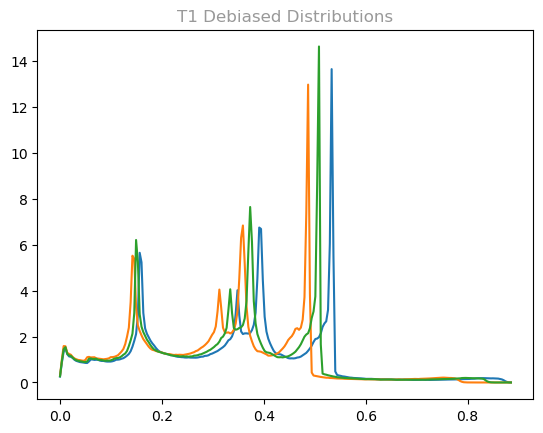

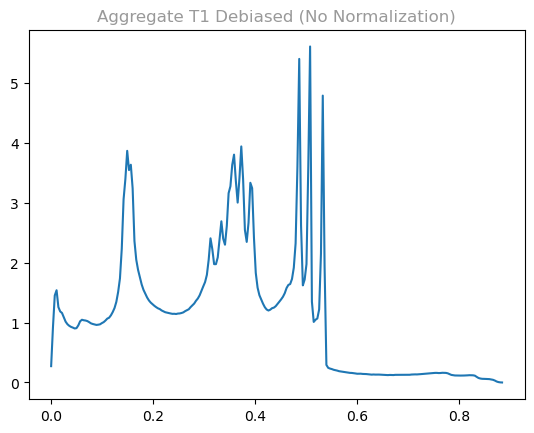

In [12]:
# View debiased intensity distributions
t1_debiased_coll = [brainweb_deb_ex0[0], brainweb_deb_ex1[0], brainweb_deb_ex2[0]]
view_utils.view_distributions(t1_debiased_coll, bandwidth=1e-2, mask_volume=data_mask, 
                              title_name='T1 Debiased Distributions')

# See the aggregate T1 distribution with no normalization
view_utils.view_distributions(t1_debiased_coll, bandwidth=1e-2, mask_volume=data_mask, combine=True,
                              title_name='Aggregate T1 Debiased (No Normalization)')

Without an absolute scaling we can get good per patient intensity recovery but incorrect aggregate distribution recovery. To fix this we will normalize each debiased image to the largest estimated class mean. 

Ideally this should match the farthest peak of the original true distribution which is at about 0.6 intensity. Note that below the peaks have broadened due to small differences in the estimated means. However both the number of peaks and their height order has been preserved by the normalization.

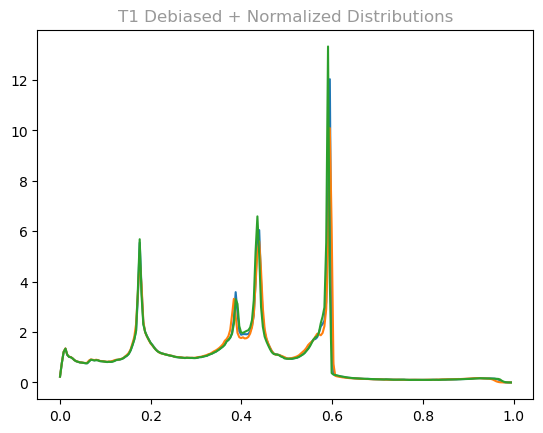

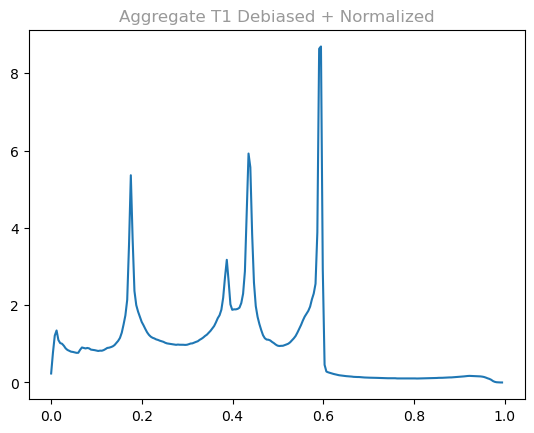

In [13]:
# Approximate location of farthest peak for true data.
# In practice this can be set to any fixed value of choice.
TRGT = 0.6

# Normalize the 3 examples
brainweb_norm_ex0 = lapgm.normalize(brainweb_deb_ex0, params_ex0, target_intensity=TRGT)
brainweb_norm_ex1 = lapgm.normalize(brainweb_deb_ex1, params_ex1, target_intensity=TRGT)
brainweb_norm_ex2 = lapgm.normalize(brainweb_deb_ex2, params_ex2, target_intensity=TRGT)

# View normalized intensity distributions
t1_normalized_coll = [brainweb_norm_ex0[0], brainweb_norm_ex1[0], brainweb_norm_ex2[0]]
view_utils.view_distributions(t1_normalized_coll, bandwidth=1e-2, mask_volume=data_mask, 
                              title_name='T1 Debiased + Normalized Distributions')

# Now try viewing the aggregate distribution using normalized data
view_utils.view_distributions(t1_normalized_coll, bandwidth=1e-2, mask_volume=data_mask, combine=True,
                              title_name='Aggregate T1 Debiased + Normalized')